In [5]:
# test loadCESMLE

import cccmautils as cutl
import loadCESMLE as cle

%matplotlib inline

cle = reload(cle)

regions = {'EUR': 'eurasiamori',
           'BKS': 'bksmori',
           'GM': 'gm',
           'NH': 'nh',
           'EPAC': 'etroppac'}

local=True

savez500 = False # save 2D to npy files. Else, load
savesat = False

npydir = '/HOME/rkm/pyscripts/pynpyfiles/'

casename = 'B20TRC5CNBDRD-BRCP85C5CNBDRD'
timesel = '1979-01-01,2012-12-31'
timeselc = '1979-01-01,1989-12-31'
timeselp = '2002-01-01,2012-12-31'

sea='DJF'


cle = reload(cle)
lat=cle.get_lat(local=local)
lon=cle.get_lon(local=local)
nlat=len(lat); nlon=len(lon)


lat: squeezing data upon read all
lon: squeezing data upon read all


In [32]:
obspath= '/HOME/rkm/work/DATA/'
obspath2 = '/HOME/rkm/work/BCs/'

graveraint= 9.80665 # m/s2 (different from Canadian models)

regions = {'EUR': 'eurasiamori',
           'BKS': 'bksmori'}

fnames={'sat': obspath + 'GISS/gistemp1200_ERSSTv4.nc',
           'z500': obspath + 'ERAINT/td_era_int_197901_201507_gp_128_64_phi500_1979011612-2015071612.nc',
        'slp': obspath + 'ERAINT/td_era_int_197901_latest_gp_128_64_pmsl.001_1979011612-2015121612.nc',
        'sic': obspath2 + 'NSIDC/td_bootstrap_197811_latest_128_64_sicn_1978111600-2013121612.nc'}
fields={'sat': 'tempanomaly',
        'z500': 'PHI',
        'slp': 'PMSL',
        'sic': 'SICN'}
convsobs = {'sat': 100,
         'z500': 1/graveraint,
         'slp': 1,
         'sic': 100} # @@@@@NOTE have to mult by scale_factor for GISS sat -- no longer works in cccmaNC?? 3/21/16



# OBS: LOAD DATA
sea='DJF'

flddt={}; fldregdt={}; latdt={}; londt={}; xxdt={}
for fkey in fnames.keys():
    fname = fnames[fkey]
    conv = convsobs[fkey]
    print fname, fields[fkey], conv
    
    fld = cnc.getNCvar(fname,fields[fkey],timesel=timesel,seas=sea)*conv 
    latdt[fkey] = cnc.getNCvar(fname,'lat')
    londt[fkey] = cnc.getNCvar(fname,'lon')

    flddt[fkey] = fld

    regdt={}
    for regkey in regions.keys():
        print regkey
        if fkey=='sic': 
            if regkey =='EUR':
                # this will be garbage
                alsomask=None
            else:
                alsomask='land'
        else: 
            alsomask=None
            
        regdt[regkey] = cutl.calc_regmean(fld,latdt[fkey],londt[fkey],
                                          regions[regkey],model=None,alsomask=alsomask)

    
    xxdt[fkey] = np.arange(0,len(regdt[regkey])) # length of last reg good for all reg in field
    fldregdt[fkey] = regdt
    


eursat=fldregdt['sat']['EUR']
bksz500 = fldregdt['z500']['BKS']
eurz500 = fldregdt['z500']['EUR']
bkssic = fldregdt['sic']['BKS']
print bksz500.shape, bkssic.shape

#bksz5002=bksz500[:-2] # this should match "anomaly time periods"
#eurz5002=eurz500[:-2]
#eursat2=eursat[:-2]
circind = (bksz500-bksz500[:10].mean())/bksz500.std() - (eurz500-eurz500[:10].mean())/eurz500.std()

testobscircanom = circind[-10:].mean() - circind[:10].mean()
testobseuranom = eursat[-10:].mean() - eursat[:10].mean()
print testobscircanom
print testobseuranom



/HOME/rkm/work/BCs/NSIDC/td_bootstrap_197811_latest_128_64_sicn_1978111600-2013121612.nc SICN 100
lat: squeezing data upon read all
lon: squeezing data upon read all
BKS
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
EUR
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
/HOME/rkm/work/DATA/ERAINT/td_era_int_197901_201507_gp_128_64_phi500_1979011612-2015071612.nc PHI 0.101971621298
lat: squeezing data upon read all
lon: squeezing data upon read all
BKS
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
EUR
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
/HOME/rkm/work/DATA/ERAINT/td_era_int_197901_latest_gp_128_64_pmsl.001_1979011612-2015121612.nc PMSL 1
lat: squeezing data upon read all
lon: squeezing data upon read all
BKS
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
EUR
calc_regmean() removing extra lon. fld new shape: (33, 64, 128)
/HOME/rkm/work/DATA/GISS/gistemp1200_ERSSTv4.nc tempanomaly 100
var_scale 

In [4]:
# ========== 1D data =============
fdicteursat = {'field': 'TREFHT'+ regions['EUR'], 'ncfield': 'TREFHT', 'comp': 'cam'}
conv=1
cledateursat = cle.load_LEdata(fdicteursat,casename,timesel=timesel, 
                       rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True)

fdicteurz = {'field': 'Z3500'+ regions['EUR'], 'ncfield': 'Z3', 'comp': 'cam'}
conv=1
cledateurz = cle.load_LEdata(fdicteurz,casename,timesel=timesel, 
                       rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True)
fdictbksz = {'field': 'Z3500'+ regions['BKS'], 'ncfield': 'Z3', 'comp': 'cam'}
conv=1
cledatbksz = cle.load_LEdata(fdictbksz,casename,timesel=timesel, 
                       rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True) # @@@@

fdictbkssic = {'field': 'aice_nh'+ regions['BKS'], 'ncfield': 'aice', 'comp': 'cice'}
conv=1
cledatbkssic = cle.load_LEdata(fdictbkssic,casename,timesel=timesel, 
                       rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True) # @@@@

print cledateursat.shape
print cledatbksz.shape


#clebkssicr = cutl.seasonalize(ledatbkssic.T,season=sea)
cleeursatr = cutl.seasonalize(cledateursat.T,season=sea)
cleeurzr = cutl.seasonalize(cledateurz.T,season=sea)
clebkszr = cutl.seasonalize(cledatbksz.T,season=sea)
clebkssicr = cutl.seasonalize(cledatbkssic.T,season=sea)

print cleeursatr.shape




/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.001.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.002.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.003.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.004.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.005.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.006.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBDRD-BRCP85C5CNBDRD.f09_g16.007.cam.h0.TREFHTeurasiamori.192001-202012.nc
/HOME/rkm/work/DATA/cesm1//TREFHTeurasiamori/b.e11.B20TRC5CNBD

In [6]:
def load_process_field(fdict, conv=1, 
                       timeselc='1979-01-01,1989-12-31',
                       timeselp='2002-01-01,2012-12-31', 
                       sea='DJF',
                       verb=False):
    """ returns processed data for timeselc, timeselp in tuple
    """

    clefldspc={}; clefldspp={}
    for cleii in range(1,31):

        subens = (cleii,cleii+1)
        print subens


        # get 2D data 

        clec = cle.load_LEdata(fdict,casename,timesel=timeselc, 
                               rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=verb,
                                subens=subens) 
        print clec.shape    

        # move time into first dimension
        clec = np.transpose(clec,(1,0,2))
        clec = np.squeeze(cutl.seasonalize(clec,season=sea))
        clefldspc[cleii] = clec.mean(axis=0)
        print clefldspc[cleii].shape


        clep = cle.load_LEdata(fdict,casename,timesel=timeselp, 
                               rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=verb,
                                subens=subens) 
        print clep.shape    

        # move time into first dimension
        clep = np.transpose(clep,(1,0,2))
        clep = np.squeeze(cutl.seasonalize(clep,season=sea))
        clefldspp[cleii] = clep.mean(axis=0)
        print clefldspp[cleii].shape


    cleretc = np.array(clefldspc.values())
    cleretp = np.array(clefldspp.values())    
    # Now we have CTL and PERT time average spatial maps for e/ ens member
    
    return cleretc, cleretp

In [7]:
# calculate regressions w/ space
def slopemap(inr,insp,dims):
    """   
          inr is 1D [time or numens]
          insp is 2D [time or numens x space.flat]
          dims are a tuple of dims to reshape space to (nlat,nlon) 

          returns slopemap [dims]           
    """ 
    #print inr.shape, insp.shape
    
    slope,intercept = np.polyfit(inr,insp, 1)
    slopemap = slope.reshape(dims)

    return slopemap

In [8]:
# ============= 2D DATA =================
if savez500:
    
    # get 2D data (Z500)
    conv=1
    fdictz = {'field': 'Z3500', 'ncfield': 'Z3', 'comp': 'cam'} # spatial
    
    clez500spc, clez500spp = load_process_field(fdictz)
    
    """clez500spc={}; clez500spp={}
    for cleii in range(1,31):

        subens = (cleii,cleii+1)
        print subens

        clec = cle.load_LEdata(fdictz,casename,timesel=timeselc, 
                               rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True,
                                subens=subens) 
        print clec.shape    

        # move time into first dimension
        clec = np.transpose(clec,(1,0,2))
        clec = np.squeeze(cutl.seasonalize(clec,season=sea))
        clez500spc[cleii] = clec.mean(axis=0)
        print clez500spc[cleii].shape


        clep = cle.load_LEdata(fdictz,casename,timesel=timeselp, 
                               rettype='ndarray',conv=conv,ftype='fullts',local=local,verb=True,
                                subens=subens) 
        print clep.shape    

        # move time into first dimension
        clep = np.transpose(clep,(1,0,2))
        clep = np.squeeze(cutl.seasonalize(clep,season=sea))
        clez500spp[cleii] = clep.mean(axis=0)
        print clez500spp[cleii].shape


    clez500spc = np.array(clez500spc.values())
    clez500spp = np.array(clez500spp.values())"""
    print clez500spc.shape
    print clez500spp.shape
    
    # Now we have CTL and PERT time average spatial maps for e/ ens member

        
    matname = npydir + 'regressdat/cesm/z500spctl_' + \
        sea + '_LEtimeavg' + timeselc +'.npy' 
    np.save(matname,np.array(clez500spc))
    
    matname = npydir + 'regressdat/cesm/z500sppert_' + \
        sea + '_LEtimeavg' + timeselp +'.npy' 
    np.save(matname,np.array(clez500spp))

else:
    matname = npydir + 'regressdat/cesm/z500spctl_' + \
        sea + '_LEtimeavg' + timeselc +'.npy' 
    clez500spc = np.load(matname)
    
    matname = npydir + 'regressdat/cesm/z500sppert_' + \
        sea + '_LEtimeavg' + timeselp +'.npy' 
    clez500spp = np.load(matname)

In [9]:
if savesat:
    fdictsat = {'field': 'TREFHT', 'ncfield': 'TREFHT', 'comp': 'cam'}
    conv=1

    clesatspc, clesatspp = load_process_field(fdictsat)
    
    matname = npydir + 'regressdat/cesm/satspctl_' + \
        sea + '_LEtimeavg' + timeselc +'.npy' 
    np.save(matname,np.array(clesatspc))
    
    matname = npydir + 'regressdat/cesm/satsppert_' + \
        sea + '_LEtimeavg' + timeselp +'.npy' 
    np.save(matname,np.array(clesatspp))

else:
    matname = npydir + 'regressdat/cesm/satspctl_' + \
        sea + '_LEtimeavg' + timeselc +'.npy' 
    clesatspc = np.load(matname)
    
    matname = npydir + 'regressdat/cesm/satsppert_' + \
        sea + '_LEtimeavg' + timeselp +'.npy' 
    clesatspp = np.load(matname)
    
    

In [10]:
# calc anomalies for regression across ensemble

clesatspan = clesatspp - clesatspc
clez500span = clez500spp - clez500spc


In [17]:

print cleeursatr.shape
# what about interannual correlations in e/ simulation:
#  first create circ index
clecirc = clebkszr/clebkszr.std(axis=0)-cleeurzr/cleeurzr.std(axis=0)
print clecirc.shape

# #### to match CanESM (scatter plot):
clecirczstd = (clebkszr-clebkszr.mean(axis=0))/clebkszr.std(axis=0) -\
                  (cleeurzr-cleeurzr.mean(axis=0))/cleeurzr.std(axis=0)
clecirczstdan = clecirczstd[-10:,...].mean(axis=0) - clecirczstd[:10,...].mean(axis=0)
# ####

clemmt,clebbt,clervt,clepvt = cutl.regress(clecirc,cleeursatr)
print clervt.shape
clemmtdtr,clebbtdtr,clervtdtr,clepvtdtr = cutl.regress(cutl.detrend(clecirc,axis=0),cutl.detrend(cleeursatr,axis=0))
print clervtdtr.shape


cleeursatranom = cleeursatr[-10:].mean(axis=0) - cleeursatr[:10].mean(axis=0)
cleeurzranom = cleeurzr[-10:].mean(axis=0) - cleeurzr[:10].mean(axis=0)
clebkszranom = clebkszr[-10:].mean(axis=0) - clebkszr[:10].mean(axis=0)
clebkssicranom = clebkssicr[-10:].mean(axis=0) - clebkssicr[:10].mean(axis=0)


# for CanESM I don't think I calc'd the ensemble circ index w/ std of each term.
clecircanom = clebkszranom/clebkszranom.std() - cleeurzranom/cleeurzranom.std()
clecirczan = clebkszranom - cleeurzranom
clecirczanstd = clecirczan / clecirczan.std()
clebkssicranstd = clebkssicranom / clebkssicranom.std()

print clecirczan.shape
print clecirczanstd.shape


(33, 30)
(33, 30)
(30,)
(30,)
(30,)
(30,)


(30,)
regress mm,bb,pval,rval: -0.289700083125 0.625144132035 7.34318504456e-06 -0.719801323118
-0.289700083125 0.625144132035 -0.719801323118 7.34318504456e-06
regress mm,bb,pval,rval: -0.509526052552 0.737754133035 0.000516777961963 -0.595528991187
-0.509526052552 0.737754133035 -0.595528991187 0.000516777961963
(33, 30)
min/max slopes -1.23034464959, -0.587015128983
min/max correlations -0.911963328555, -0.639183937873


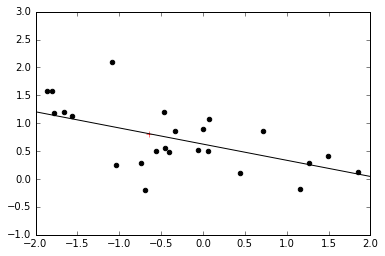

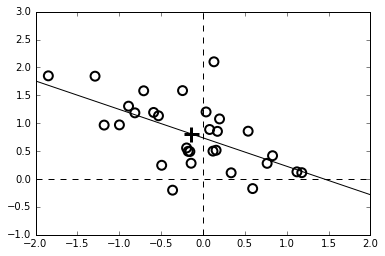

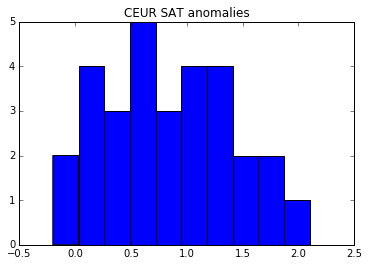

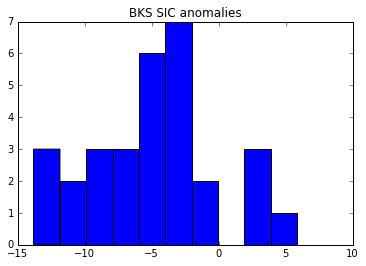

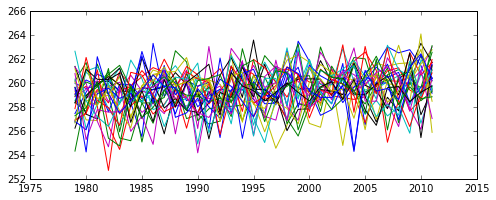

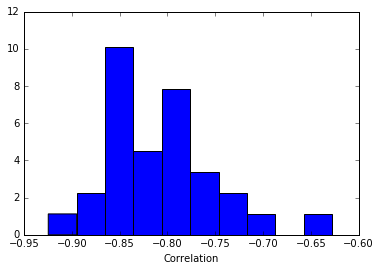

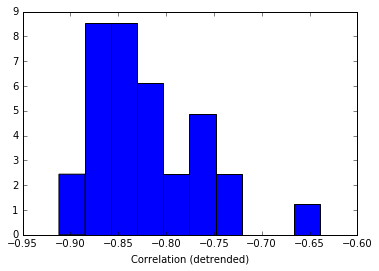

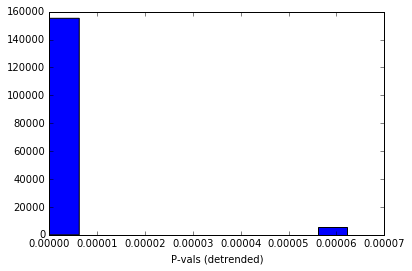

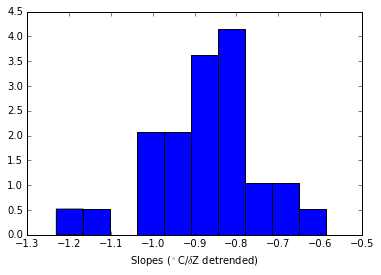

In [16]:
print clecircanom.shape

# this is what is plotted in paper scatter plot for CanESM
# lecirczrstd = (lebkszr-lebkszr.mean(axis=0))/lebkszr.std(axis=0) -\
#                  (leeurzr-leeurzr.mean(axis=0))/leeurzr.std(axis=0)
# lecirczrstdan = lecirczrstd[-10:,...].mean(axis=0) - lecirczrstd[:10,...].mean(axis=0)
# What does it mean to regress spatially on a different metric? @@@@@@

plt.figure()
plt.scatter(clecircanom,cleeursatranom,color='k')
plt.plot(clecircanom.mean(),cleeursatranom.mean(),marker='+',color='r')
cplt.add_regressline(clecircanom,cleeursatranom,color='k')
plt.xlim((-2,2))
plt.ylim((-1,3))

mm,bb,rval,pval = cutl.regress(clecircanom,cleeursatranom)
print mm,bb,rval,pval 

# this one like CanESM paper fig
plt.figure()
plt.scatter(clecirczstdan,cleeursatranom,linewidths=2,edgecolor='k',s=80, facecolors='none', marker='o')
plt.plot(clecirczstdan.mean(),cleeursatranom.mean(),marker='+',markersize=15,color='k',mew=3,mec='k')
plt.xlim((-2,2))
plt.ylim((-1,3))
cplt.add_regressline(clecirczstdan,cleeursatranom,color='k')
plt.axvline(x=0,linestyle='--',color='k')
plt.axhline(y=0,linestyle='--',color='k')

mm,bb,rval,pval = cutl.regress(clecirczstdan,cleeursatranom)
print mm,bb,rval,pval 


plt.figure()
plt.hist(cleeursatranom)
plt.title('CEUR SAT anomalies')

plt.figure()
plt.hist(clebkssicranom)
plt.title('BKS SIC anomalies')


xx = np.arange(1979,2012)
print cleeursatr.shape
plt.figure(figsize=(8,3))
ret = plt.plot(xx,cleeursatr)


plt.figure()
plt.hist(clervt,normed=True)
plt.xlabel('Correlation')

plt.figure()
plt.hist(clervtdtr,normed=True)
plt.xlabel('Correlation (detrended)')

plt.figure()
plt.hist(clepvtdtr,normed=True)
plt.xlabel('P-vals (detrended)')

plt.figure()
plt.hist(clemmtdtr,normed=True)
plt.xlabel('Slopes ($^\circ$C/$\delta$Z detrended)')

print 'min/max slopes ' + str(np.min(clemmtdtr)) + ', ' + str(np.max(clemmtdtr))
print 'min/max correlations ' + str(np.min(clervtdtr)) + ', ' + str(np.max(clervtdtr))


In [18]:

z500oncircz = slopemap(clecirczanstd,clez500span,(nlat,nlon)) # Z500 regress on circidx
satoncircz = slopemap(clecirczanstd,clesatspan,(nlat,nlon)) # SAT regress on circidx

z500onsic = slopemap(clebkssicranstd,clez500span,(nlat,nlon)) # Z500 regress on regSIC
satonsic = slopemap(clebkssicranstd,clesatspan,(nlat,nlon)) # SAT regress on regSIC


Z500 contours
[-15. -12.  -9.  -6.  -3.   3.   6.   9.  12.  15.]


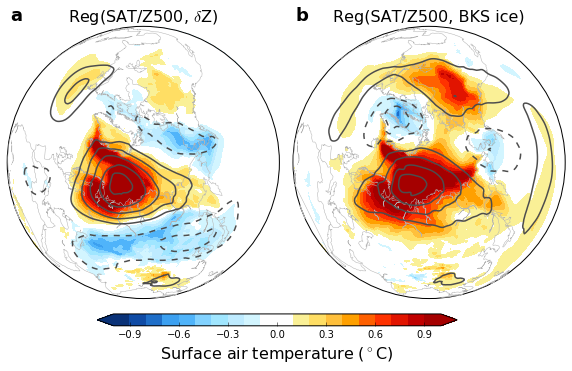

In [20]:
printtofile=False

cminsp=-1; cmaxsp=1
cminsp2=-3; cmaxsp2=3
#cminsp2=-2.5; cmaxsp2=2.5

cmlen=15.
incr = (cmaxsp2-cminsp2) / (cmlen)
conts = np.arange(cminsp2,cmaxsp2+incr,incr)


plotparams = {'lcol':'0.7', 'cmin': cminsp, 'cmax': cmaxsp, 'suppcb': True,
              'ptype': 'nheur', 'coastres': 'c', 'coastwidth': 0.5, 
              'area_thresh':70000}
contcol='0.3'
fsz=18
lws=1.5



ttl1='Reg(SAT/Z500, $\delta$Z)' 
ttl2='Reg(SAT/Z500, BKS ice)' 

cmlenz=10.
incrz = (15-(-15)) / (cmlenz)
tmpz = np.arange(-15,15+incrz,incrz)
# remove zero contour
contsz = np.zeros(len(tmpz)-1)
contsz[0:5] = tmpz[0:5]
contsz[5:] = tmpz[6:]


print 'Z500 contours'
print contsz



fig,axs=plt.subplots(1,2)
fig.set_size_inches(10,5.5)
fig.subplots_adjust(wspace=0.05)
ax=axs[0]
bm,pc=cplt.kemmap(satoncircz,lat,lon,axis=ax,
                  title=ttl1, panellab='a',**plotparams) 
#cplt.add_contours(bm, slponcircp,lat,lon,levels=conts,colors=contcol,linewidths=lws)
cplt.add_contours(bm, z500oncircz,lat,lon,levels=contsz,colors=contcol,linewidths=lws)

ax.set_title(ttl1,fontsize=fsz-2)

ax=axs[1]
bm,pc=cplt.kemmap(-satonsic,lat,lon,axis=ax,
                  title=ttl2, panellab='b',**plotparams) 
#cplt.add_contours(bm,-slponsic,lat,lon,levels=conts,colors=contcol,linewidths=lws)
cplt.add_contours(bm,-z500onsic,lat,lon,levels=contsz,colors=contcol,linewidths=lws)
ax.set_title(ttl2,fontsize=fsz-2)

cplt.add_colorbar(fig,pc,orientation='horizontal', pos=[.25,.1, .5,.03],
                  label='Surface air temperature ($^\circ$C)',fontsize=16)

if printtofile:
    fig.savefig('CESMLE_regressiononcircidx_bkssic.pdf')
    fig.savefig('CESMLE_regressiononcircidx_bkssic.png',dpi=300)


-0.526536518145 0.00279829277325
Regress circ index anom on bks sic anom. mm units (m/%)
mm,pval -1.9064410277 0.00279829277325
Portion of circ index anom associated with BKS SIC anom, for e/ ens member
[26.3478780379273 5.045443100333395 5.970560995137293 10.049969024580246
 5.125090580824687 8.411598156025981 8.96328748961969 23.43484960010133
 13.84389450464953 10.388059262114789 15.133656885205017 20.99053314175903
 11.644247125378554 6.284726629896529 4.9729610802466695 -5.297041291790133
 9.924275432558453 20.873888562202414 18.07618756613454 16.419967497038783
 14.574093297646309 22.67176270024853 10.602768464190229 4.900169575078964
 0.22282028081210978 6.591569423411016 -3.912285204935256
 -11.163941770116992 1.7326405413751513 -5.490940975598287]
the residual (ie circ index anom - sea ice associated portion), standardized (no units)
[-2.5805309935921703 -0.7729642234395434 0.8022411580149537
 -0.7726385612212017 -0.5446412141278993 -1.304478837994994
 1.0914999589971415 0.447

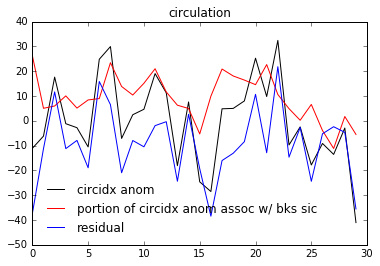

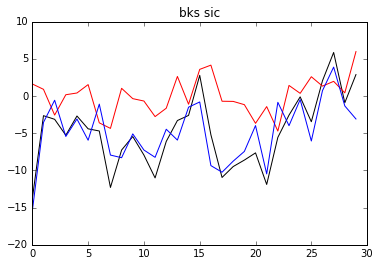

In [29]:
# Now want to remove the portion of the regression on circ index that is due to BKS SIC
#   BKS SIC is independent var (x) and circ index is dependent (y)

mmstd, bbstd, rvalstd, pvalstd = cutl.regress(clebkssicranstd, clecirczanstd) # these are standardized
#  mm is std circ / std %
print mmstd, pvalstd

mm, bb, rval, pval = cutl.regress(clebkssicranom, clecirczan) 
# mm is m / %
print 'Regress circ index anom on bks sic anom. mm units (m/%)'
print 'mm,pval ' + str(mm), str(pval)

# portion of circ index anom explained by bks sic, for each ens member:
clecirczrdue2bkssic = clebkssicranom*mm # units are m
print 'Portion of circ index anom associated with BKS SIC anom, for e/ ens member'
print clecirczrdue2bkssic # shape is 50 

# the residual, for each ens member
clecirczrnobkssic = clecirczan - clecirczrdue2bkssic # units are m
clecirczrnobkssicstd = clecirczrnobkssic/clecirczrnobkssic.std() # no units (STD)
print 'the residual (ie circ index anom - sea ice associated portion), standardized (no units)'
print clecirczrnobkssicstd

plt.figure
plt.plot(clecirczan,'k')
plt.plot(clecirczrdue2bkssic,'r')
plt.plot(clecirczrnobkssic,'b')
plt.title('circulation')
plt.legend(('circidx anom','portion of circidx anom assoc w/ bks sic','residual'),
           frameon=False,loc='best')

# now redo spatial regressions (on standardized residual):
satoncircnosic = slopemap(clecirczrnobkssicstd,clesatspan,(nlat,nlon)) # SAT regress on circidx residual
z500oncircnosic = slopemap(clecirczrnobkssicstd,clez500span,(nlat,nlon)) # Z500 regress on circidx residual




# NOW DO THE REVERSE (BKS SIC DUE TO CIRC IDX)
mm2, bb2, rval2, pval2 = cutl.regress(clecirczan,clebkssicranom) 
# mm is % / m
print mm2, pval2

# portion of bks sic explained by circulation index:
clebkssicrdue2circ = clecirczan*mm2 # units are %

# the residual
clebkssicrnocirc = clebkssicranom - clebkssicrdue2circ  # units are %
clebkssicrnocircstd = clebkssicrnocirc/clebkssicrnocirc.std() # no units (STD)

plt.figure()
plt.plot(clebkssicranom,'k')
plt.plot(clebkssicrdue2circ,'r')
plt.plot(clebkssicrnocirc, 'b')
plt.title('bks sic')


# now redo spatial regressions (on standardized residual)
satonsicnocirc = slopemap(clebkssicrnocircstd,clesatspan,(nlat,nlon)) # SAT regress on regSIC
z500onsicnocirc = slopemap(clebkssicrnocircstd,clez500span,(nlat,nlon)) # Z500 regress on regSIC


(<matplotlib.axes._axes.Axes at 0x2ab1e98c6bd0>,
 <matplotlib.colorbar.Colorbar at 0x2ab1f1b1c9d0>)

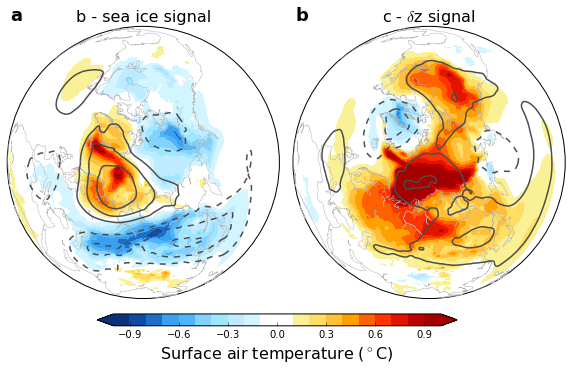

In [30]:
ttl1 = 'b - sea ice signal'
ttl2 = 'c - $\delta$z signal'

fig,axs=plt.subplots(1,2)
fig.set_size_inches(10,5.5)
fig.subplots_adjust(wspace=0.05)
ax=axs[0]
bm,pc=cplt.kemmap(satoncircnosic,lat,lon,axis=ax,
                  title=ttl1, panellab='a',**plotparams) 
#cplt.add_contours(bm, slponcircp,lat,lon,levels=conts,colors=contcol,linewidths=lws)
cplt.add_contours(bm, z500oncircnosic,lat,lon,levels=contsz,colors=contcol,linewidths=lws)

ax.set_title(ttl1,fontsize=fsz-2)

ax=axs[1]
bm,pc=cplt.kemmap(-satonsicnocirc,lat,lon,axis=ax,
                  title=ttl2, panellab='b',**plotparams) 
#cplt.add_contours(bm,-slponsic,lat,lon,levels=conts,colors=contcol,linewidths=lws)
cplt.add_contours(bm,-z500onsicnocirc,lat,lon,levels=contsz,colors=contcol,linewidths=lws)
ax.set_title(ttl2,fontsize=fsz-2)

cplt.add_colorbar(fig,pc,orientation='horizontal', pos=[.25,.1, .5,.03],
                  label='Surface air temperature ($^\circ$C)',fontsize=16)


[-15. -12.  -9.  -6.  -3.   3.   6.   9.  12.  15.]


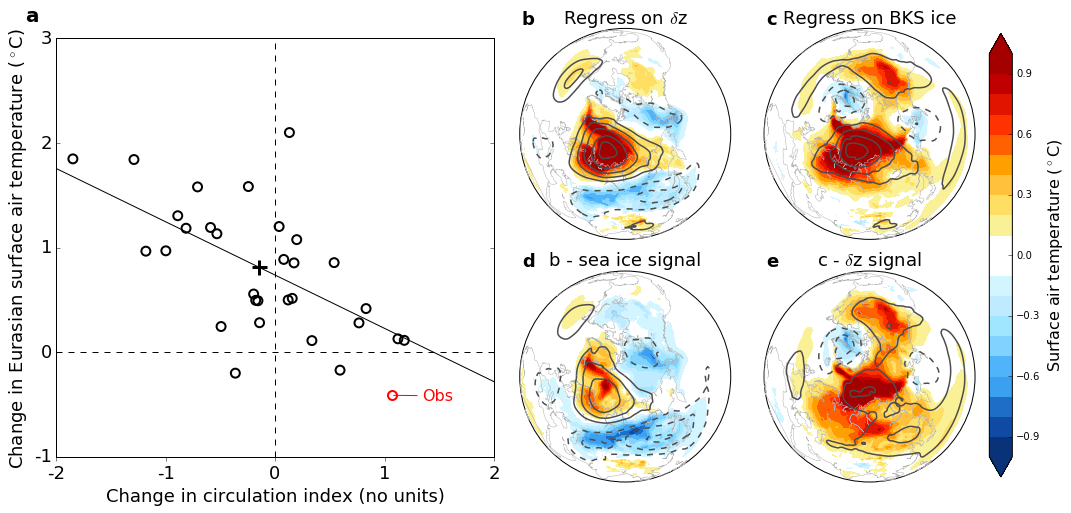

In [36]:
# Supplementary figure for paper:
printtofile=True


# COMBINE SCATTER WITH MAPS FOR PAPER
from matplotlib import gridspec


dohoriz=True

contcol='0.3'
fsz=18
lws=1.5

cminsp=-1; cmaxsp=1
cminsp2=-15; cmaxsp2=15

lons, lats = np.meshgrid(lon,lat)
cmlenb=15. # for reg on bks sic
incrb = (cmaxsp2-cminsp2) / (cmlenb)
contsb = np.arange(cminsp2,cmaxsp2+incrb,incrb)

cmlen=10. # for reg on circ idx
incr = (cmaxsp2-cminsp2) / (cmlen)
conts = np.arange(cminsp2,cmaxsp2+incr,incr)

contsb=conts # same conts for both
conts=contsb=conts[np.logical_or(conts<0, conts>0)] # get rid of zero line


print conts

ttl1='Regress on $\delta$z' #Circulation congruent'
ttl2='Regress on BKS ice' #Sea ice congruent'
ttl3='b - sea ice signal'
ttl4='c - $\delta$z signal'

plotparams = {'lcol':'0.7', 'cmin': cminsp, 'cmax': cmaxsp, 'suppcb': True,
              'ptype': 'nheur', 'coastres': 'c', 'coastwidth': 0.5, 
              'area_thresh':70000}



if dohoriz:
    fig = plt.figure(figsize=(16,7))
    gs1 = gridspec.GridSpec(2,2)
    gs1.update(top=0.93, left=0.09, bottom=0.1,right=0.47)
else:
    fig = plt.figure(figsize=(7,16))
    gs1 = gridspec.GridSpec(2,2)
    gs1.update(top=0.95,bottom = 0.57, left=0.09, right=0.95)

ax=plt.subplot(gs1[0:,0:])
ax.scatter(clecirczstdan,cleeursatranom, linewidths=2,edgecolor='k',s=80, facecolors='none', marker='o')
ax.plot(clecirczstdan.mean(),cleeursatranom.mean(), marker='+',markersize=15,color='k',mew=3,mec='k')

ax.plot(testobscircanom,testobseuranom,marker='o',markersize=9,markerfacecolor='none',color='r',markeredgewidth=2,mec='r')
ax.annotate('Obs', xy=(testobscircanom,testobseuranom), 
            xycoords='data',
            textcoords='offset points',xytext=(30,-5),
            arrowprops=dict(arrowstyle='-',
                            facecolor='r', edgecolor='r'), fontsize=fsz-2, color='r') 
            #,connectionstyle='arc3'#xytext = (testobscircanom+.1,testobseuranom), 
ax.set_xlabel('Change in circulation index (no units)', fontsize=fsz)
ax.set_ylabel('Change in Eurasian surface air temperature ($^\circ$C)', fontsize=fsz)
ax.set_ylim((-1,3))
ax.set_xlim((-2,2))

ax.axvline(x=0,linestyle='--',color='k')
ax.axhline(y=0,linestyle='--',color='k')

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_tick_params(direction='out',which='both')
#ax.tick_params('x', length=7, width=2, which='major',labelsize=fsz-2)
#ax.tick_params('x', length=3, width=1, which='minor')
ax.tick_params('y',labelsize=fsz-2)
ax.tick_params('x',labelsize=fsz-2)

##ax.minorticks_on()
ax.set_yticks(np.arange(-1,4))
ax.set_yticklabels(np.arange(-1,4),fontsize=fsz)
ax.set_xticks(np.arange(-2,3))
ax.set_xticklabels(np.arange(-2,3),fontsize=fsz)

testmm,testbb,test_r,test_p = cutl.regress(clecirczstdan,cleeursatranom) # mm, bb, r-val, p-val
#plt.annotate('r='+str(test_r),xy=(.7,.85),xycoords='figure fraction')

axylims = ax.get_ylim()
axxlims = ax.get_xlim()
onex=np.linspace(axxlims[0],axxlims[1])
ax.plot(onex,testmm*onex + testbb, color='k',linewidth=1)
ax.annotate('a',xy=(-0.07,1.04),xycoords='axes fraction',fontsize=fsz+2,fontweight='bold')



# here want to put a 2x2 subplot.
gs2 = gridspec.GridSpec(2,2)
if dohoriz:
    gs2.update(top=0.95, left=0.48, bottom=0.05, 
               wspace=0.02,hspace=0.15)
else:
    gs2.update(top=0.5, left=0.09, bottom=0.05, right=0.97, 
               wspace=0.05,hspace=0.05)

ax=plt.subplot(gs2[0,0])
bm,pc=cplt.kemmap(satoncircz,lat,lon, axis=ax,
                  panellab='b',**plotparams) 
cplt.add_contours(bm, z500oncircz,lat,lon,levels=conts,colors=contcol,linewidths=lws)
ax.set_title(ttl1,fontsize=fsz)

ax=plt.subplot(gs2[0,1])
bm,pc=cplt.kemmap(-satonsic,lat,lon,axis=ax,
                  panellab='c',**plotparams)
cplt.add_contours(bm, -z500onsic,lat,lon,levels=contsb,colors=contcol,linewidths=lws)
ax.set_title(ttl2,fontsize=fsz)

ax=plt.subplot(gs2[1,0])
bm,pc=cplt.kemmap(satoncircnosic,lat,lon,axis=ax,
                  panellab='d',**plotparams) #cmin=cminsp,cmax=cmaxsp,
cplt.add_contours(bm, z500oncircnosic,lat,lon,levels=conts,colors=contcol,linewidths=lws)
#ax.set_xlabel('contours -15,15, interval=' + str(np.diff(conts)[0]) + 'm')
ax.set_title(ttl3,fontsize=fsz)

ax=plt.subplot(gs2[1,1])
bm,pc=cplt.kemmap(-satonsicnocirc,lat,lon,axis=ax,
                  panellab='e',**plotparams)
cplt.add_contours(bm, -z500onsicnocirc,lat,lon,levels=contsb,colors=contcol,linewidths=lws)
#ax.set_xlabel('contour -15,15, interval=' + str(np.diff(contsb)[0]) + 'm')
ax.set_title(ttl4,fontsize=fsz)

if dohoriz:
    #cbarpos=(0.53,0.07, 0.43,0.03)
    #cplt.add_colorbar(fig,pc,orientation='horizontal', pos=cbarpos,
    #                  label='Surface air temperature ($^\circ$C)',fontsize=16)
    cbarpos=(0.9,0.06, 0.02,0.88)
    cplt.add_colorbar(fig,pc,orientation='vertical', pos=cbarpos,
                      label='Surface air temperature ($^\circ$C)',fontsize=16)
else:
    cbarpos=(0.11,0.03, 0.83,0.02)
    cplt.add_colorbar(fig,pc,orientation='horizontal', pos=cbarpos,
                      label='Surface air temperature ($^\circ$C)',fontsize=16)

if printtofile:
    if dohoriz:
        fig.savefig('SuppFigure_CESMLE_scatterregmaps_horiz.pdf')
        fig.savefig('SuppFigure_CESMLE_scatterregmaps_horiz.eps',format='eps',dpi=400)
        fig.savefig('SuppFigure_CESMLE_scatterregmaps_horiz.png',format='eps',dpi=400)
    else:
        fig.savefig('SuppFigure_CESMLE_scatterregmaps.pdf')
        fig.savefig('SuppFigure_CESMLE_scatterregmaps.eps',format='eps',dpi=600)